# Tunisian Olive Oil Production Analysis & Prediction
# Based on FAO Tunisia Olive Sector Analysis

Enhanced Tunisian Olive Oil Production Cost Prediction System

1. LOADING DATASET WITH COST INFORMATION
--------------------------------------------------
Dataset shape: (5000, 42)
Date range: 2021-01-01 00:00:00 to 2023-12-30 00:00:00
Missing values: 0
✅ All cost columns found!

2. COST DATA EXPLORATION
----------------------------------------
Cost Column Statistics (TND - Tunisian Dinars):
       Electricity_Cost_TND  Water_Cost_TND  Total_Labor_Cost_TND  \
count           5000.000000     5000.000000           5000.000000   
mean             543.736438        7.233629            571.946223   
std              335.698850        5.071219            691.560665   
min               11.558000        0.140000              7.500000   
25%              297.105500        3.523500            178.665500   
50%              466.725500        5.927500            347.292000   
75%              712.860500        9.583250            721.987250   
max             2330.155000       37.467000          

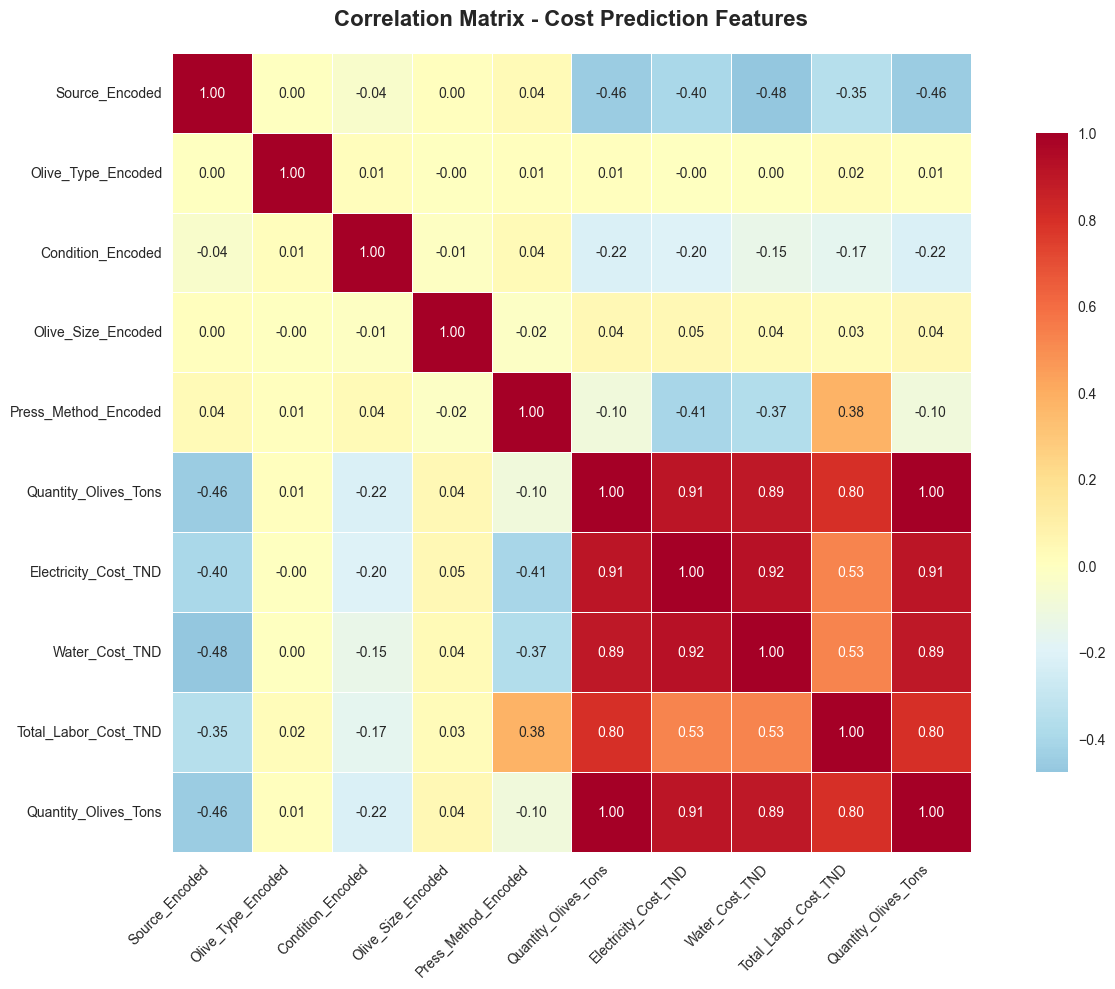


7. COST PREDICTION MODEL TRAINING
----------------------------------------
Training set shape: (3592, 6)
Cost targets shape: (3592, 3)
All targets shape: (3592, 9)

8. TRAINING COST PREDICTION MODELS
----------------------------------------
Training models for COST prediction (Electricity, Water, Labor)...

Training Random Forest for cost prediction...
Random Forest - Cost Targets: MSE=1847.78, R²=0.960, MAE=24.37

Training Gradient Boosting for cost prediction...
Gradient Boosting - Cost Targets: MSE=1646.29, R²=0.965, MAE=23.41

Training Neural Network for cost prediction...
Neural Network - Cost Targets: MSE=1815.63, R²=0.963, MAE=25.31

Training Ridge Regression for cost prediction...
Ridge Regression - Cost Targets: MSE=6846.94, R²=0.893, MAE=53.11

Training models for ALL targets (costs + production)...

Training Random Forest for all targets...
Random Forest - All Targets: MSE=2137795.77, R²=0.942, MAE=376.62

Training Gradient Boosting for all targets...
Gradient Boosting - Al

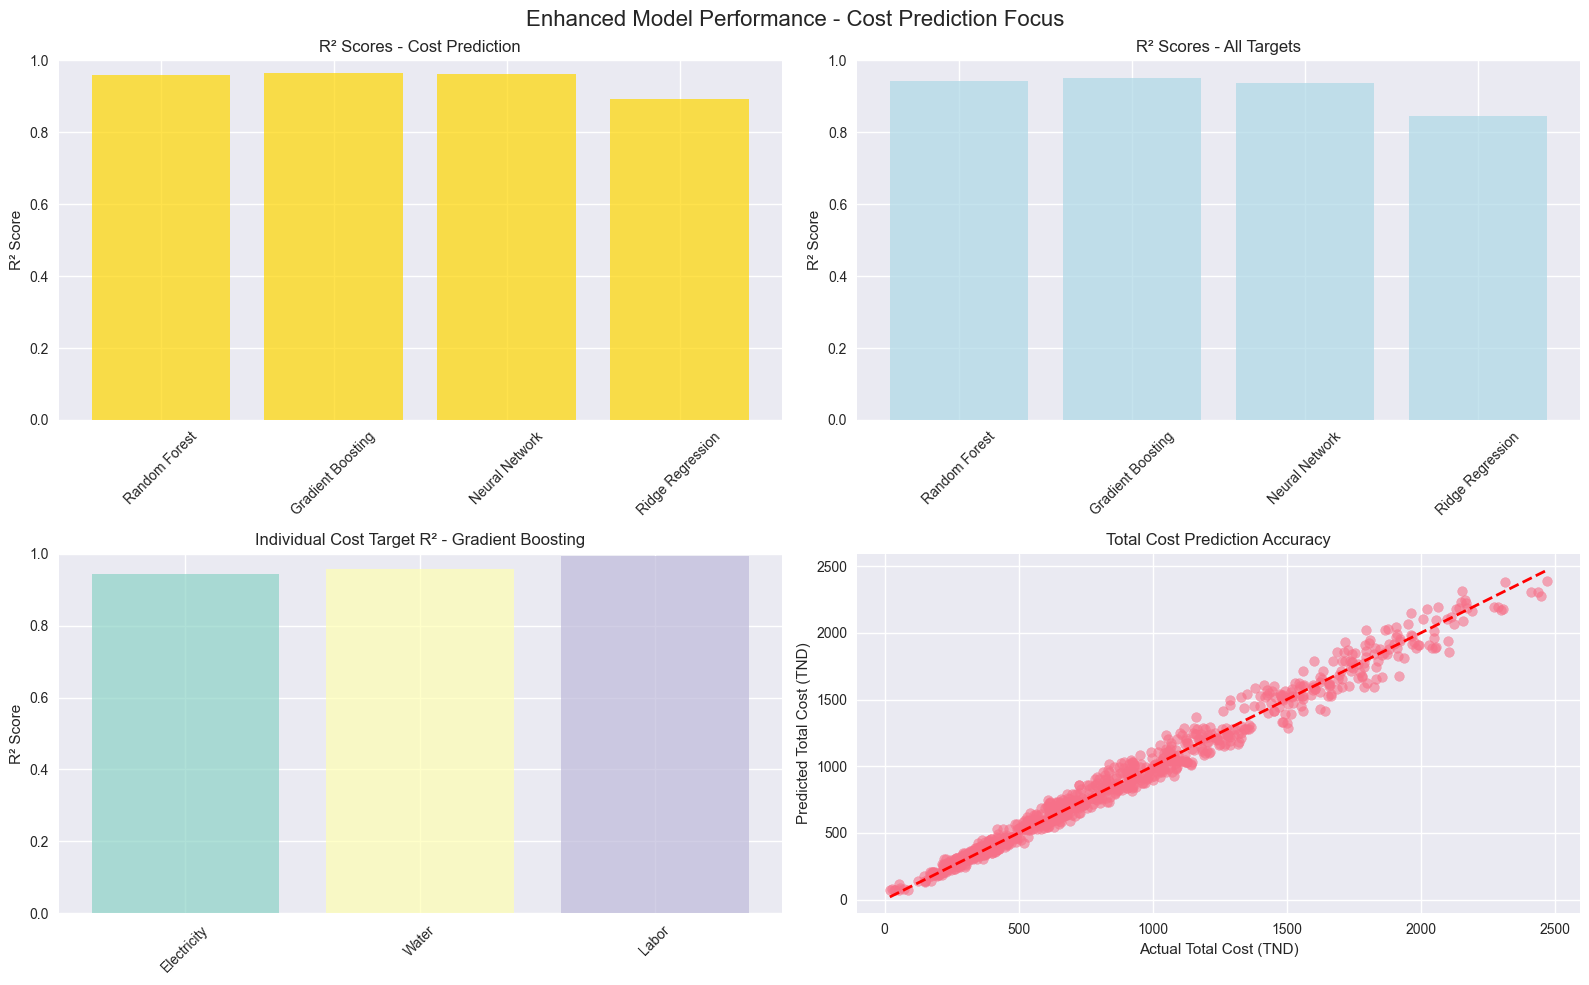


10. DETAILED COST PREDICTION ANALYSIS
----------------------------------------
Individual Cost Target Performance (Gradient Boosting):
  Electricity_Cost_TND:
    R² Score: 0.943
    MAE: 49.082 TND
    MSE: 4232.960
  Water_Cost_TND:
    R² Score: 0.957
    MAE: 0.599 TND
    MSE: 0.667
  Total_Labor_Cost_TND:
    R² Score: 0.993
    MAE: 20.551 TND
    MSE: 705.234

Sample Cost Predictions (First 10 test samples):
------------------------------------------------------------
   Actual_Electricity  Pred_Electricity  Actual_Water  Pred_Water  \
0             908.226           846.205        11.481      12.385   
1             347.010           302.197         3.426       4.133   
2             252.690           283.653         3.409       3.526   
3             439.058           429.352         3.999       4.690   
4             378.230           368.640         4.535       4.568   
5             399.404           484.383         4.965       4.994   
6            1263.982          1089

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.neural_network import MLPRegressor
import os

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Enhanced Tunisian Olive Oil Production Cost Prediction System")
print("=" * 70)
print("\n1. LOADING DATASET WITH COST INFORMATION")
print("-" * 50)

# Load dataset - use the one with costs
df = pd.read_csv('tunisian_olive_oil_production_with_costs.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check if cost columns exist
cost_columns = [
    'Electricity_Cost_TND', 
    'Water_Cost_TND', 
    'Total_Labor_Cost_TND',
    'Total_Operational_Cost_TND'
]

missing_cost_cols = [col for col in cost_columns if col not in df.columns]
if missing_cost_cols:
    print(f"⚠️ Missing cost columns: {missing_cost_cols}")
    print("Please ensure you're using the dataset with cost information.")
else:
    print("✅ All cost columns found!")

print("\n2. COST DATA EXPLORATION")
print("-" * 40)

# Display cost statistics
print("Cost Column Statistics (TND - Tunisian Dinars):")
if all(col in df.columns for col in cost_columns):
    cost_stats = df[cost_columns].describe()
    print(cost_stats)
else:
    print("Cost columns not available. Creating synthetic cost data...")
    # Create synthetic costs based on consumption if missing
    if 'Total_Energy_Consumption_kWh' in df.columns:
        df['Electricity_Cost_TND'] = df['Total_Energy_Consumption_kWh'] * 0.352
    if 'Water_Consumption_m3' in df.columns:
        df['Water_Cost_TND'] = df['Water_Consumption_m3'] * 0.200
    elif 'Water_Consumption_Liters' in df.columns:
        df['Water_Cost_TND'] = (df['Water_Consumption_Liters'] / 1000) * 0.200
    
    # Estimate labor costs based on employees and processing time
    if 'Total_Employees' in df.columns and 'Processing_Time_Hours' in df.columns:
        df['Total_Labor_Cost_TND'] = df['Total_Employees'] * df['Processing_Time_Hours'] * 3.5  # avg wage
    
    df['Total_Operational_Cost_TND'] = (df['Electricity_Cost_TND'] + 
                                       df['Water_Cost_TND'] + 
                                       df['Total_Labor_Cost_TND'])

print("\n3. ENHANCED DATA PREPROCESSING")
print("-" * 40)

# Create a copy for processing
df_clean = df.copy()

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    df_no_outliers = df.copy()
    outliers_removed = 0
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            before_count = len(df_no_outliers)
            df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & 
                                           (df_no_outliers[col] <= upper_bound)]
            after_count = len(df_no_outliers)
            outliers_removed += (before_count - after_count)
            print(f"Column {col}: Removed {before_count - after_count} outliers")
    
    return df_no_outliers, outliers_removed

# Define numerical columns for outlier detection
numerical_cols = ['Quantity_Olives_Tons', 'Oil_Quantity_Tons', 'Processing_Time_Hours',
                 'Total_Energy_Consumption_kWh', 'Water_Consumption_Liters',
                 'Electricity_Cost_TND', 'Water_Cost_TND', 'Total_Labor_Cost_TND']

df_clean, total_outliers = remove_outliers_iqr(df_clean, numerical_cols)
print(f"\nTotal outliers removed: {total_outliers}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# Enhanced feature engineering
print("\n4. ENHANCED FEATURE ENGINEERING")
print("-" * 40)

# Create efficiency metrics
df_clean['Extraction_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Quantity_Olives_Tons']
df_clean['Energy_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Total_Energy_Consumption_kWh']
df_clean['Water_Efficiency'] = df_clean['Oil_Quantity_Tons'] / df_clean['Water_Consumption_Liters']
df_clean['Worker_Productivity'] = df_clean['Oil_Quantity_Tons'] / df_clean['Total_Employees']

# Create cost per unit metrics
df_clean['Cost_per_Ton_Oil'] = df_clean['Total_Operational_Cost_TND'] / df_clean['Oil_Quantity_Tons']
df_clean['Energy_Cost_per_kWh'] = df_clean['Electricity_Cost_TND'] / df_clean['Total_Energy_Consumption_kWh']
df_clean['Labor_Cost_per_Hour'] = df_clean['Total_Labor_Cost_TND'] / df_clean['Processing_Time_Hours']

# Encode categorical variables
le_source = LabelEncoder()
le_olive_type = LabelEncoder()
le_condition = LabelEncoder()
le_size = LabelEncoder()
le_press = LabelEncoder()

df_clean['Source_Encoded'] = le_source.fit_transform(df_clean['Source'])
df_clean['Olive_Type_Encoded'] = le_olive_type.fit_transform(df_clean['Olive_Type'])
df_clean['Condition_Encoded'] = le_condition.fit_transform(df_clean['Condition'])
df_clean['Olive_Size_Encoded'] = le_size.fit_transform(df_clean['Olive_Size'])
df_clean['Press_Method_Encoded'] = le_press.fit_transform(df_clean['Press_Method'])

print("Enhanced feature engineering completed")

print("\n5. COST PREDICTION MODEL SETUP")
print("-" * 40)

# Define input features (what we know before processing)
input_features = [
    'Source_Encoded', 'Olive_Type_Encoded', 'Condition_Encoded', 
    'Olive_Size_Encoded', 'Press_Method_Encoded', 'Quantity_Olives_Tons'
]

# Define cost targets (what we want to predict)
cost_targets = [
    'Electricity_Cost_TND',
    'Water_Cost_TND', 
    'Total_Labor_Cost_TND'
]

# Define other production targets
production_targets = [
    'Oil_Quality_Score',
    'Oil_Quantity_Tons',
    'Processing_Time_Hours',
    'Total_Energy_Consumption_kWh',
    'Water_Consumption_Liters',
    'Total_Employees'
]

# All targets combined
all_targets = cost_targets + production_targets

print(f"Input features: {input_features}")
print(f"Cost targets: {cost_targets}")
print(f"Production targets: {production_targets}")

print("\n6. COST CORRELATION ANALYSIS")
print("-" * 40)

# Analyze correlations between inputs and costs
cost_correlation_features = input_features + cost_targets + ['Quantity_Olives_Tons']
cost_correlation_matrix = df_clean[cost_correlation_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(cost_correlation_matrix, 
            annot=True,           
            cmap='RdYlBu_r',     
            center=0,             
            square=True,          
            fmt='.2f',           
            cbar_kws={"shrink": .8},  
            linewidths=0.5)

plt.title('Correlation Matrix - Cost Prediction Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n7. COST PREDICTION MODEL TRAINING")
print("-" * 40)

# Prepare data for cost prediction
X = df_clean[input_features]
y_costs = df_clean[cost_targets]
y_all = df_clean[all_targets]

# Split data
X_train, X_test, y_costs_train, y_costs_test = train_test_split(
    X, y_costs, test_size=0.2, random_state=42
)

X_train_all, X_test_all, y_all_train, y_all_test = train_test_split(
    X, y_all, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_all_scaled = scaler.fit_transform(X_train_all)
X_test_all_scaled = scaler.transform(X_test_all)

print(f"Training set shape: {X_train.shape}")
print(f"Cost targets shape: {y_costs_train.shape}")
print(f"All targets shape: {y_all_train.shape}")

# Define models
models = {
    'Random Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'Neural Network': MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)),
    'Ridge Regression': MultiOutputRegressor(Ridge(alpha=1.0))
}

print("\n8. TRAINING COST PREDICTION MODELS")
print("-" * 40)

cost_results = {}
all_results = {}

# Train models for cost prediction
print("Training models for COST prediction (Electricity, Water, Labor)...")
for name, model in models.items():
    print(f"\nTraining {name} for cost prediction...")
    
    # Train on cost targets
    model_cost = model
    model_cost.fit(X_train_scaled, y_costs_train)
    y_costs_pred = model_cost.predict(X_test_scaled)
    
    # Calculate metrics for cost targets
    mse_cost = mean_squared_error(y_costs_test, y_costs_pred)
    r2_cost = r2_score(y_costs_test, y_costs_pred)
    mae_cost = mean_absolute_error(y_costs_test, y_costs_pred)
    
    cost_results[name] = {
        'model': model_cost,
        'mse': mse_cost,
        'r2': r2_cost,
        'mae': mae_cost,
        'predictions': y_costs_pred
    }
    
    print(f"{name} - Cost Targets: MSE={mse_cost:.2f}, R²={r2_cost:.3f}, MAE={mae_cost:.2f}")

# Train models for all targets
print("\nTraining models for ALL targets (costs + production)...")
for name, model in models.items():
    print(f"\nTraining {name} for all targets...")
    
    # Create new instance for all targets
    if name == 'Random Forest':
        model_all = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    elif name == 'Gradient Boosting':
        model_all = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
    elif name == 'Neural Network':
        model_all = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
    else:  # Ridge
        model_all = MultiOutputRegressor(Ridge(alpha=1.0))
    
    model_all.fit(X_train_all_scaled, y_all_train)
    y_all_pred = model_all.predict(X_test_all_scaled)
    
    # Calculate metrics for all targets
    mse_all = mean_squared_error(y_all_test, y_all_pred)
    r2_all = r2_score(y_all_test, y_all_pred)
    mae_all = mean_absolute_error(y_all_test, y_all_pred)
    
    all_results[name] = {
        'model': model_all,
        'mse': mse_all,
        'r2': r2_all,
        'mae': mae_all,
        'predictions': y_all_pred
    }
    
    print(f"{name} - All Targets: MSE={mse_all:.2f}, R²={r2_all:.3f}, MAE={mae_all:.2f}")

print("\n9. MODEL PERFORMANCE COMPARISON")
print("-" * 40)

# Find best models
best_cost_model_name = max(cost_results.keys(), key=lambda k: cost_results[k]['r2'])
best_all_model_name = max(all_results.keys(), key=lambda k: all_results[k]['r2'])

print(f"Best model for COST prediction: {best_cost_model_name} (R² = {cost_results[best_cost_model_name]['r2']:.3f})")
print(f"Best model for ALL targets: {best_all_model_name} (R² = {all_results[best_all_model_name]['r2']:.3f})")

# Create performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Enhanced Model Performance - Cost Prediction Focus', fontsize=16)

model_names = list(cost_results.keys())

# Cost prediction R² scores
r2_scores_cost = [cost_results[name]['r2'] for name in model_names]
axes[0,0].bar(model_names, r2_scores_cost, color='gold', alpha=0.7)
axes[0,0].set_title('R² Scores - Cost Prediction')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# All targets R² scores
r2_scores_all = [all_results[name]['r2'] for name in model_names]
axes[0,1].bar(model_names, r2_scores_all, color='lightblue', alpha=0.7)
axes[0,1].set_title('R² Scores - All Targets')
axes[0,1].set_ylabel('R² Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylim(0, 1)

# Individual cost target performance (best model)
best_cost_pred = cost_results[best_cost_model_name]['predictions']
for i, target in enumerate(cost_targets):
    target_r2 = r2_score(y_costs_test.iloc[:, i], best_cost_pred[:, i])
    axes[1,0].bar(i, target_r2, color=plt.cm.Set3(i), alpha=0.7)

axes[1,0].set_title(f'Individual Cost Target R² - {best_cost_model_name}')
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_xticks(range(len(cost_targets)))
axes[1,0].set_xticklabels(['Electricity', 'Water', 'Labor'], rotation=45)
axes[1,0].set_ylim(0, 1)

# Cost prediction accuracy scatter
axes[1,1].scatter(y_costs_test.sum(axis=1), best_cost_pred.sum(axis=1), alpha=0.6)
axes[1,1].plot([y_costs_test.sum(axis=1).min(), y_costs_test.sum(axis=1).max()], 
               [y_costs_test.sum(axis=1).min(), y_costs_test.sum(axis=1).max()], 'r--', lw=2)
axes[1,1].set_xlabel('Actual Total Cost (TND)')
axes[1,1].set_ylabel('Predicted Total Cost (TND)')
axes[1,1].set_title('Total Cost Prediction Accuracy')

plt.tight_layout()
plt.show()

print("\n10. DETAILED COST PREDICTION ANALYSIS")
print("-" * 40)

# Use best cost model for detailed analysis
best_cost_model = cost_results[best_cost_model_name]['model']
best_cost_predictions = cost_results[best_cost_model_name]['predictions']

# Print individual cost target performance
print(f"Individual Cost Target Performance ({best_cost_model_name}):")
for i, target in enumerate(cost_targets):
    target_r2 = r2_score(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    target_mae = mean_absolute_error(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    target_mse = mean_squared_error(y_costs_test.iloc[:, i], best_cost_predictions[:, i])
    
    print(f"  {target}:")
    print(f"    R² Score: {target_r2:.3f}")
    print(f"    MAE: {target_mae:.3f} TND")
    print(f"    MSE: {target_mse:.3f}")

# Show sample predictions
print(f"\nSample Cost Predictions (First 10 test samples):")
print("-" * 60)
cost_comparison = pd.DataFrame({
    'Actual_Electricity': y_costs_test.iloc[:10, 0].values,
    'Pred_Electricity': best_cost_predictions[:10, 0],
    'Actual_Water': y_costs_test.iloc[:10, 1].values,
    'Pred_Water': best_cost_predictions[:10, 1],
    'Actual_Labor': y_costs_test.iloc[:10, 2].values,
    'Pred_Labor': best_cost_predictions[:10, 2],
})
print(cost_comparison.round(3))

# Calculate total costs
actual_total = y_costs_test.sum(axis=1)
predicted_total = best_cost_predictions.sum(axis=1)
total_cost_r2 = r2_score(actual_total, predicted_total)

print(f"\nTotal Cost Prediction Performance:")
print(f"  R² Score: {total_cost_r2:.3f}")
print(f"  Average Actual Cost: {actual_total.mean():.2f} TND")
print(f"  Average Predicted Cost: {predicted_total.mean():.2f} TND")

print("\n11. FEATURE IMPORTANCE FOR COST PREDICTION")
print("-" * 40)

# Get feature importance from Random Forest (if it's the best model or available)
if best_cost_model_name == 'Random Forest' or 'Random Forest' in cost_results:
    rf_cost_model = cost_results['Random Forest']['model']
    
    # Random Forest provides feature importance for each target
    print("Feature Importance for Cost Prediction (Random Forest):")
    
    for i, target in enumerate(cost_targets):
        print(f"\n{target}:")
        # Get feature importance for this specific target
        estimator = rf_cost_model.estimators_[i]
        importance = estimator.feature_importances_
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        for rank, idx in enumerate(indices):
            feature_name = input_features[idx]
            print(f"  {rank+1}. {feature_name}: {importance[idx]:.3f}")

print("\n12. COST PREDICTION DEPLOYMENT")
print("-" * 40)

# Save enhanced models
os.makedirs('enhanced_models', exist_ok=True)

# Save cost prediction model
joblib.dump(best_cost_model, 'enhanced_models/cost_prediction_model.joblib')
joblib.dump(scaler, 'enhanced_models/cost_scaler.joblib')

# Save all targets model
best_all_model = all_results[best_all_model_name]['model']
joblib.dump(best_all_model, 'enhanced_models/all_targets_model.joblib')

# Save encoders
encoders = {
    'source': le_source,
    'olive_type': le_olive_type, 
    'condition': le_condition,
    'size': le_size,
    'press_method': le_press
}

import pickle
with open('enhanced_models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# Save model info
enhanced_model_info = {
    'input_features': input_features,
    'cost_targets': cost_targets,
    'production_targets': production_targets,
    'all_targets': all_targets,
    'best_cost_model': best_cost_model_name,
    'best_all_model': best_all_model_name,
    'cost_r2_score': cost_results[best_cost_model_name]['r2'],
    'all_r2_score': all_results[best_all_model_name]['r2']
}

with open('enhanced_models/enhanced_model_info.pkl', 'wb') as f:
    pickle.dump(enhanced_model_info, f)

print("Enhanced models saved successfully!")
print(f"  - Cost prediction model: enhanced_models/cost_prediction_model.joblib")
print(f"  - All targets model: enhanced_models/all_targets_model.joblib")
print(f"  - Scaler: enhanced_models/cost_scaler.joblib")
print(f"  - Encoders: enhanced_models/encoders.pkl")
print(f"  - Model info: enhanced_models/enhanced_model_info.pkl")

print("\n13. PREDICTION FUNCTION")
print("-" * 40)

def predict_olive_oil_costs(source, olive_type, condition, olive_size, press_method, quantity_olives):
    """
    Predict olive oil production costs and outputs
    
    Parameters:
    - source: 'Nord', 'Centre', 'Sud', 'Sfax'
    - olive_type: 'Chemlali', 'Chétoui', 'Oueslati', etc.
    - condition: 'Rainfed', 'Irrigated'  
    - olive_size: 'Small', 'Medium', 'Large'
    - press_method: 'Traditionnel', 'Super-presses', 'Méthode en continu'
    - quantity_olives: quantity in tons
    
    Returns:
    - Dictionary with cost and production predictions
    """
    
    # Encode inputs
    try:
        encoded_input = np.array([[
            le_source.transform([source])[0],
            le_olive_type.transform([olive_type])[0],
            le_condition.transform([condition])[0],
            le_size.transform([olive_size])[0],
            le_press.transform([press_method])[0],
            quantity_olives
        ]])
        
        # Scale input
        encoded_scaled = scaler.transform(encoded_input)
        
        # Predict costs
        cost_pred = best_cost_model.predict(encoded_scaled)[0]
        
        # Predict all targets
        all_pred = best_all_model.predict(encoded_scaled)[0]
        
        results = {
            'costs': {
                'electricity_cost_tnd': round(cost_pred[0], 3),
                'water_cost_tnd': round(cost_pred[1], 3),
                'labor_cost_tnd': round(cost_pred[2], 3),
                'total_cost_tnd': round(sum(cost_pred), 3)
            },
            'production': {
                'oil_quality_score': round(all_pred[3], 1),
                'oil_quantity_tons': round(all_pred[4], 2),
                'processing_time_hours': round(all_pred[5], 1),
                'energy_consumption_kwh': round(all_pred[6], 1),
                'water_consumption_liters': round(all_pred[7], 0),
                'total_employees': round(all_pred[8], 0)
            }
        }
        
        return results
        
    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# Test the prediction function
print("Testing prediction function:")
test_result = predict_olive_oil_costs(
    source='Nord',
    olive_type='Chemlali', 
    condition='Irrigated',
    olive_size='Large',
    press_method='Méthode en continu',
    quantity_olives=50
)

print("Sample prediction:")
print(f"Costs: {test_result['costs']}")
print(f"Production: {test_result['production']}")

print("\n" + "="*70)
print("ENHANCED OLIVE OIL COST PREDICTION MODEL COMPLETE!")
print("="*70)
print(f"✅ Now predicts the 3 most important costs:")
print(f"   - Electricity Cost (TND)")
print(f"   - Water Cost (TND)")  
print(f"   - Labor Cost (TND)")
print(f"✅ Plus all production parameters")
print(f"✅ Models saved and ready for deployment")
print("="*70)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


def calculate_prediction_differences(y_actual, y_predicted, target_names, model_name="Model"):
    """
    Calculate comprehensive difference metrics between actual and predicted values
    """
    results = {
        'model_name': model_name,
        'target_analysis': {},
        'overall_metrics': {},
        'difference_statistics': {}
    }

    # Convert to DataFrame and reset index to avoid indexing issues
    if isinstance(y_actual, pd.DataFrame):
        y_actual_df = y_actual.reset_index(drop=True)
    else:
        y_actual_df = pd.DataFrame(y_actual, columns=target_names)
    
    y_predicted_df = pd.DataFrame(y_predicted, columns=target_names)

    print(f"PREDICTION DIFFERENCE ANALYSIS FOR {model_name}")
    print("=" * 60)

    # Individual target analysis
    for i, target in enumerate(target_names):
        # Use iloc for safe indexing
        if isinstance(y_actual_df, pd.DataFrame):
            actual_values = y_actual_df.iloc[:, i].values
        else:
            actual_values = y_actual[:, i]
        
        predicted_values = y_predicted[:, i]

        # Calculate differences
        absolute_differences = np.abs(actual_values - predicted_values)
        
        # Handle division by zero for relative differences
        mask = actual_values != 0
        relative_differences = np.full_like(actual_values, np.inf)
        if mask.sum() > 0:
            relative_differences[mask] = (predicted_values[mask] - actual_values[mask]) / actual_values[mask] * 100

        # Calculate metrics
        mse = mean_squared_error(actual_values, predicted_values)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual_values, predicted_values)
        r2 = r2_score(actual_values, predicted_values)

        # Calculate MAPE (handle division by zero)
        if mask.sum() > 0:
            mape = mean_absolute_percentage_error(actual_values[mask], predicted_values[mask])
        else:
            mape = float('inf')

        # Statistical analysis of differences
        finite_relative_diffs = relative_differences[np.isfinite(relative_differences)]
        
        target_stats = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2_score': r2,
            'mape_percent': mape * 100,
            'mean_actual': np.mean(actual_values),
            'mean_predicted': np.mean(predicted_values),
            'mean_absolute_diff': np.mean(absolute_differences),
            'max_absolute_diff': np.max(absolute_differences),
            'min_absolute_diff': np.min(absolute_differences),
            'std_absolute_diff': np.std(absolute_differences),
            'mean_relative_diff_percent': np.mean(finite_relative_diffs) if len(finite_relative_diffs) > 0 else 0,
            'median_relative_diff_percent': np.median(finite_relative_diffs) if len(finite_relative_diffs) > 0 else 0,
            'q75_absolute_diff': np.percentile(absolute_differences, 75),
            'q90_absolute_diff': np.percentile(absolute_differences, 90),
            'predictions_within_10_percent': np.sum(np.abs(finite_relative_diffs) <= 10) / len(actual_values) * 100 if len(finite_relative_diffs) > 0 else 0,
            'predictions_within_20_percent': np.sum(np.abs(finite_relative_diffs) <= 20) / len(actual_values) * 100 if len(finite_relative_diffs) > 0 else 0
        }

        results['target_analysis'][target] = target_stats

        # Print individual target results
        print(f"\n{target}:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MAPE: {mape*100:.2f}%")
        print(f"  Mean Actual: {np.mean(actual_values):.4f}")
        print(f"  Mean Predicted: {np.mean(predicted_values):.4f}")
        print(f"  Mean Abs Difference: {np.mean(absolute_differences):.4f}")
        print(f"  Max Abs Difference: {np.max(absolute_differences):.4f}")
        print(f"  Predictions within 10%: {target_stats['predictions_within_10_percent']:.1f}%")
        print(f"  Predictions within 20%: {target_stats['predictions_within_20_percent']:.1f}%")

    # Overall model performance
    overall_r2 = r2_score(y_actual_df, y_predicted_df, multioutput='uniform_average')
    overall_mae = mean_absolute_error(y_actual_df, y_predicted_df, multioutput='uniform_average')
    overall_mse = mean_squared_error(y_actual_df, y_predicted_df, multioutput='uniform_average')

    results['overall_metrics'] = {
        'overall_r2': overall_r2,
        'overall_mae': overall_mae,
        'overall_mse': overall_mse,
        'overall_rmse': np.sqrt(overall_mse)
    }

    print(f"\nOVERALL MODEL PERFORMANCE:")
    print(f"  Average R²: {overall_r2:.4f}")
    print(f"  Average MAE: {overall_mae:.4f}")
    print(f"  Average RMSE: {np.sqrt(overall_mse):.4f}")

    return results


def create_difference_visualizations(y_actual, y_predicted, target_names, model_name="Model"):
    """
    Create comprehensive visualizations of prediction differences
    """
    # Convert and reset index to avoid indexing issues
    if isinstance(y_actual, pd.DataFrame):
        y_actual_df = y_actual.reset_index(drop=True)
    else:
        y_actual_df = pd.DataFrame(y_actual, columns=target_names)

    n_targets = len(target_names)
    n_cols = min(3, n_targets)
    n_rows = (n_targets + n_cols - 1) // n_cols

    # 1. Actual vs Predicted Scatter Plots
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_targets == 1:
        axes1 = [axes1]
    elif n_rows == 1:
        axes1 = axes1.flatten()
    else:
        axes1 = axes1.flatten()

    fig1.suptitle(f'{model_name}: Actual vs Predicted Values', fontsize=16, fontweight='bold')

    for i, target in enumerate(target_names):
        actual = y_actual_df.iloc[:, i].values
        predicted = y_predicted[:, i]

        axes1[i].scatter(actual, predicted, alpha=0.6, s=50)

        # Perfect prediction line
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        axes1[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

        axes1[i].set_xlabel(f'Actual {target}')
        axes1[i].set_ylabel(f'Predicted {target}')
        axes1[i].set_title(f'{target}\nR² = {r2_score(actual, predicted):.3f}')
        axes1[i].grid(True, alpha=0.3)
        axes1[i].legend()

    # Hide empty subplots
    for j in range(n_targets, len(axes1)):
        axes1[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # 2. Residual Analysis
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_targets == 1:
        axes2 = [axes2]
    elif n_rows == 1:
        axes2 = axes2.flatten()
    else:
        axes2 = axes2.flatten()

    fig2.suptitle(f'{model_name}: Residual Analysis', fontsize=16, fontweight='bold')

    for i, target in enumerate(target_names):
        actual = y_actual_df.iloc[:, i].values
        predicted = y_predicted[:, i]
        residuals = actual - predicted

        axes2[i].scatter(predicted, residuals, alpha=0.6, s=50)
        axes2[i].axhline(y=0, color='r', linestyle='--', lw=2)
        axes2[i].set_xlabel(f'Predicted {target}')
        axes2[i].set_ylabel('Residuals')
        axes2[i].set_title(f'{target} Residuals')
        axes2[i].grid(True, alpha=0.3)

    # Hide empty subplots
    for j in range(n_targets, len(axes2)):
        axes2[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # 3. Error Distribution
    fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_targets == 1:
        axes3 = [axes3]
    elif n_rows == 1:
        axes3 = axes3.flatten()
    else:
        axes3 = axes3.flatten()

    fig3.suptitle(f'{model_name}: Error Distribution', fontsize=16, fontweight='bold')

    for i, target in enumerate(target_names):
        actual = y_actual_df.iloc[:, i].values
        predicted = y_predicted[:, i]
        absolute_errors = np.abs(actual - predicted)

        axes3[i].hist(absolute_errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes3[i].axvline(x=np.mean(absolute_errors), color='red', linestyle='--',
                         label=f'Mean: {np.mean(absolute_errors):.3f}')
        axes3[i].axvline(x=np.median(absolute_errors), color='orange', linestyle='--',
                         label=f'Median: {np.median(absolute_errors):.3f}')
        axes3[i].set_xlabel('Absolute Error')
        axes3[i].set_ylabel('Frequency')
        axes3[i].set_title(f'{target} Error Distribution')
        axes3[i].legend()
        axes3[i].grid(True, alpha=0.3)

    # Hide empty subplots
    for j in range(n_targets, len(axes3)):
        axes3[j].set_visible(False)

    plt.tight_layout()
    plt.show()


def create_difference_summary_table(results_dict, target_names):
    """
    Create a summary table of prediction differences
    """
    print("\nPREDICTION DIFFERENCE SUMMARY TABLE")
    print("=" * 100)

    summary_data = []
    for target in target_names:
        target_data = results_dict['target_analysis'][target]
        summary_data.append({
            'Target': target,
            'R²': f"{target_data['r2_score']:.4f}",
            'RMSE': f"{target_data['rmse']:.4f}",
            'MAE': f"{target_data['mae']:.4f}",
            'MAPE(%)': f"{target_data['mape_percent']:.2f}",
            'Mean_Actual': f"{target_data['mean_actual']:.4f}",
            'Mean_Predicted': f"{target_data['mean_predicted']:.4f}",
            'Max_Error': f"{target_data['max_absolute_diff']:.4f}",
            'Within_10%': f"{target_data['predictions_within_10_percent']:.1f}%",
            'Within_20%': f"{target_data['predictions_within_20_percent']:.1f}%"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    return summary_df


def detailed_error_analysis(y_actual, y_predicted, target_names):
    """
    Perform detailed error analysis including worst predictions
    """
    # Convert and reset index to avoid indexing issues
    if isinstance(y_actual, pd.DataFrame):
        y_actual_df = y_actual.reset_index(drop=True)
    else:
        y_actual_df = pd.DataFrame(y_actual, columns=target_names)

    print("\nDETAILED ERROR ANALYSIS")
    print("=" * 50)

    for i, target in enumerate(target_names):
        actual = y_actual_df.iloc[:, i].values
        predicted = y_predicted[:, i]

        # Calculate errors
        absolute_errors = np.abs(actual - predicted)
        
        # Handle division by zero for relative errors
        mask = actual != 0
        relative_errors = np.full_like(actual, 0.0)
        if mask.sum() > 0:
            relative_errors[mask] = np.abs((predicted[mask] - actual[mask]) / actual[mask] * 100)

        # Find worst and best predictions
        worst_indices = np.argsort(absolute_errors)[-5:]  # Top 5 worst
        best_indices = np.argsort(absolute_errors)[:5]   # Top 5 best

        print(f"\n{target}:")
        print(f"  Error Statistics:")
        print(f"    Min Error: {np.min(absolute_errors):.4f}")
        print(f"    Max Error: {np.max(absolute_errors):.4f}")
        print(f"    Mean Error: {np.mean(absolute_errors):.4f}")
        print(f"    Median Error: {np.median(absolute_errors):.4f}")
        print(f"    Std Error: {np.std(absolute_errors):.4f}")

        print(f"\n  Worst 5 Predictions:")
        for idx in reversed(worst_indices):
            actual_val = actual[idx]
            pred_val = predicted[idx]
            error = absolute_errors[idx]
            rel_error = relative_errors[idx]
            print(f"    Sample {idx}: Actual={actual_val:.4f}, Predicted={pred_val:.4f}, "
                  f"Error={error:.4f} ({rel_error:.2f}%)")

        print(f"\n  Best 5 Predictions:")
        for idx in best_indices:
            actual_val = actual[idx]
            pred_val = predicted[idx]
            error = absolute_errors[idx]
            rel_error = relative_errors[idx]
            print(f"    Sample {idx}: Actual={actual_val:.4f}, Predicted={pred_val:.4f}, "
                  f"Error={error:.4f} ({rel_error:.2f}%)")


def run_complete_difference_analysis(y_actual, y_predicted, target_names, model_name="Model"):
    """
    Run complete prediction difference analysis
    """
    print("COMPREHENSIVE PREDICTION DIFFERENCE ANALYSIS")
    print("=" * 80)

    # 1. Calculate difference metrics
    results = calculate_prediction_differences(y_actual, y_predicted, target_names, model_name)

    # 2. Create visualizations
    create_difference_visualizations(y_actual, y_predicted, target_names, model_name)

    # 3. Create summary table
    summary_df = create_difference_summary_table(results, target_names)

    # 4. Detailed error analysis
    detailed_error_analysis(y_actual, y_predicted, target_names)

    # 5. Export results
    print(f"\nEXPORTING RESULTS...")
    
    # Save summary table
    summary_df.to_csv(f'{model_name}_prediction_differences.csv', index=False)

    # Save detailed results
    import pickle
    with open(f'{model_name}_detailed_analysis.pkl', 'wb') as f:
        pickle.dump(results, f)

    print(f"Results saved:")
    print(f"  - Summary table: {model_name}_prediction_differences.csv")
    print(f"  - Detailed analysis: {model_name}_detailed_analysis.pkl")

    return results, summary_df

Debug Info:
y_costs_test type: <class 'pandas.core.frame.DataFrame'>
y_costs_test shape: (899, 3)
best_cost_predictions type: <class 'numpy.ndarray'>
best_cost_predictions shape: (899, 3)
COMPREHENSIVE PREDICTION DIFFERENCE ANALYSIS
PREDICTION DIFFERENCE ANALYSIS FOR Cost_Prediction_Model

Electricity_Cost_TND:
  R² Score: 0.9432
  RMSE: 65.0612
  MAE: 49.0822
  MAPE: 10.81%
  Mean Actual: 481.5277
  Mean Predicted: 483.5539
  Mean Abs Difference: 49.0822
  Max Abs Difference: 237.3186
  Predictions within 10%: 50.5%
  Predictions within 20%: 89.7%

Water_Cost_TND:
  R² Score: 0.9574
  RMSE: 0.8170
  MAE: 0.5988
  MAPE: 10.23%
  Mean Actual: 6.2520
  Mean Predicted: 6.2204
  Mean Abs Difference: 0.5988
  Max Abs Difference: 3.1570
  Predictions within 10%: 53.4%
  Predictions within 20%: 93.4%

Total_Labor_Cost_TND:
  R² Score: 0.9933
  RMSE: 26.5562
  MAE: 20.5514
  MAPE: 10.42%
  Mean Actual: 404.1967
  Mean Predicted: 406.1960
  Mean Abs Difference: 20.5514
  Max Abs Difference: 102

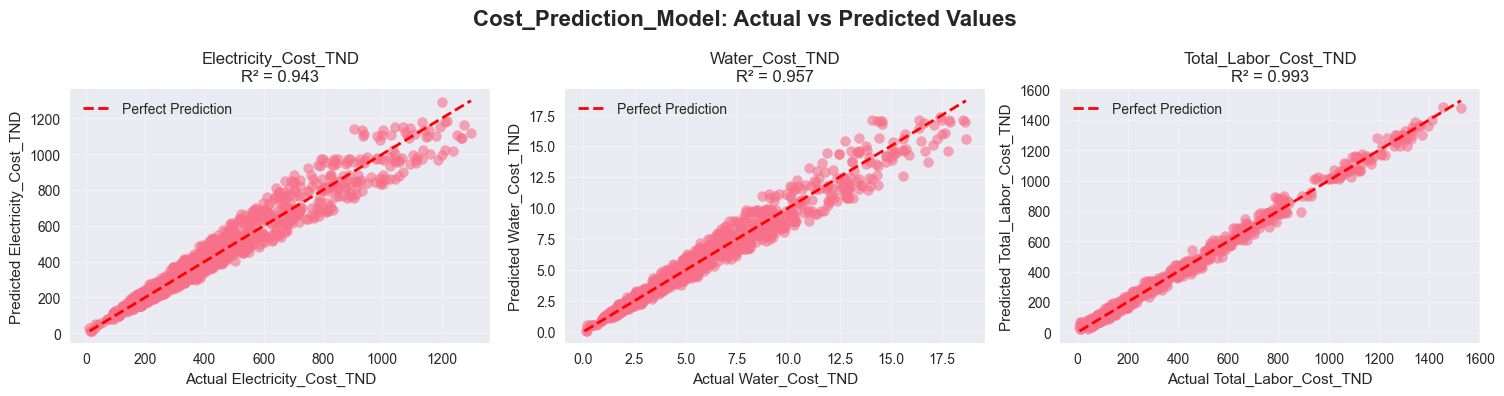

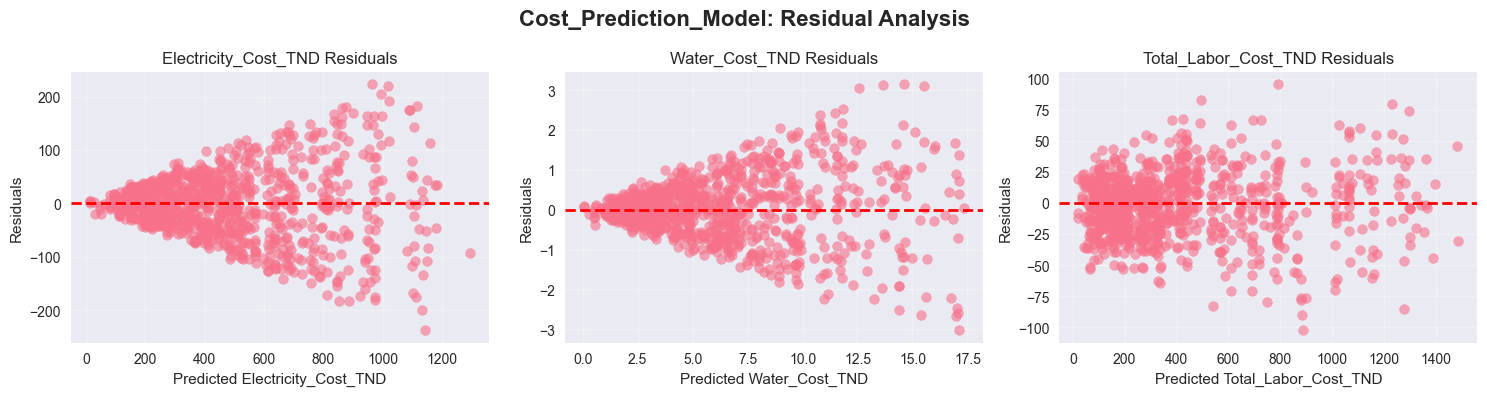

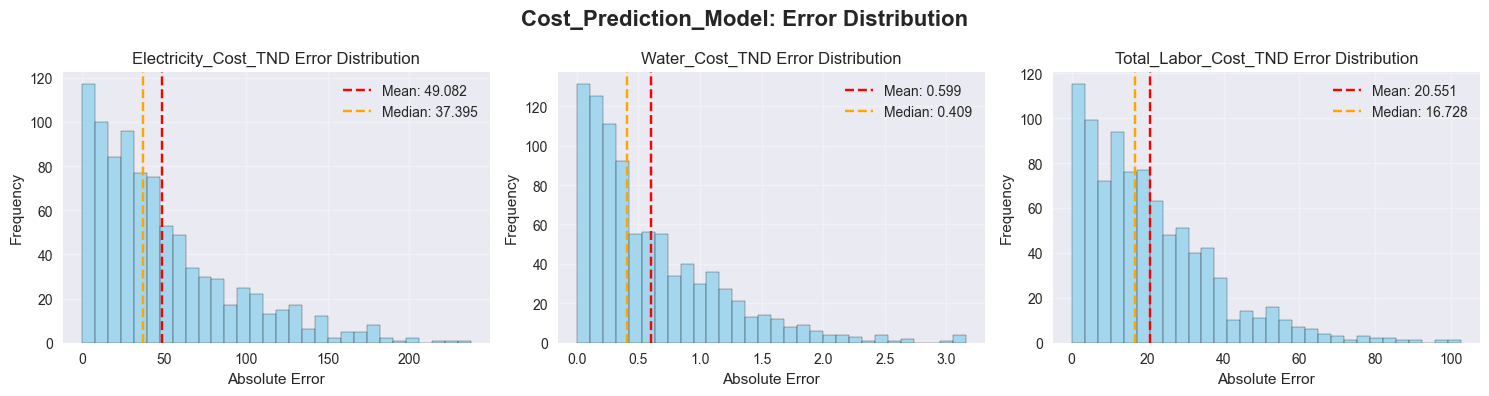


PREDICTION DIFFERENCE SUMMARY TABLE
              Target     R²    RMSE     MAE MAPE(%) Mean_Actual Mean_Predicted Max_Error Within_10% Within_20%
Electricity_Cost_TND 0.9432 65.0612 49.0822   10.81    481.5277       483.5539  237.3186      50.5%      89.7%
      Water_Cost_TND 0.9574  0.8170  0.5988   10.23      6.2520         6.2204    3.1570      53.4%      93.4%
Total_Labor_Cost_TND 0.9933 26.5562 20.5514   10.42    404.1967       406.1960  102.4433      74.2%      90.5%

DETAILED ERROR ANALYSIS

Electricity_Cost_TND:
  Error Statistics:
    Min Error: 0.0303
    Max Error: 237.3186
    Mean Error: 49.0822
    Median Error: 37.3951
    Std Error: 42.7072

  Worst 5 Predictions:
    Sample 425: Actual=905.4250, Predicted=1142.7436, Error=237.3186 (26.21%)
    Sample 624: Actual=1188.7690, Predicted=965.0792, Error=223.6898 (18.82%)
    Sample 516: Actual=1238.1490, Predicted=1019.1981, Error=218.9509 (17.68%)
    Sample 429: Actual=1199.7670, Predicted=994.7851, Error=204.9819 (17.

RuntimeError: dictionary changed size during iteration

In [12]:
# For cost prediction analysis (this worked!)
cost_targets = ['Electricity_Cost_TND', 'Water_Cost_TND', 'Total_Labor_Cost_TND']

print("Debug Info:")
print(f"y_costs_test type: {type(y_costs_test)}")
print(f"y_costs_test shape: {y_costs_test.shape if hasattr(y_costs_test, 'shape') else 'No shape attribute'}")
print(f"best_cost_predictions type: {type(best_cost_predictions)}")
print(f"best_cost_predictions shape: {best_cost_predictions.shape if hasattr(best_cost_predictions, 'shape') else 'No shape attribute'}")

cost_analysis = run_complete_difference_analysis(
    y_costs_test, 
    best_cost_predictions, 
    cost_targets, 
    "Cost_Prediction_Model"
)

# For complete model analysis - check if variables exist
all_targets = ['Electricity_Cost_TND', 'Water_Cost_TND', 'Total_Labor_Cost_TND',
               'Oil_Quality_Score', 'Oil_Quantity_Tons', 'Processing_Time_Hours',
               'Total_Energy_Consumption_kWh', 'Water_Consumption_Liters', 'Total_Employees']

print(f"\nDebug Info for complete model:")
print(f"y_all_test type: {type(y_all_test)}")
print(f"y_all_test shape: {y_all_test.shape if hasattr(y_all_test, 'shape') else 'No shape attribute'}")

# Check if best_all_predictions exists
if 'best_all_predictions' in globals():
    print(f"best_all_predictions type: {type(best_all_predictions)}")
    print(f"best_all_predictions shape: {best_all_predictions.shape if hasattr(best_all_predictions, 'shape') else 'No shape attribute'}")
    
    complete_analysis = run_complete_difference_analysis(
        y_all_test,
        best_all_predictions,
        all_targets,
        "Complete_Production_Model"
    )
else:
    print("ERROR: 'best_all_predictions' is not defined!")
    print("You need to create predictions for the complete model first.")
    print("\nPossible solutions:")
    print("1. If you have a trained complete model, use: best_all_predictions = your_complete_model.predict(X_all_test)")
    print("2. If you have another variable with complete predictions, replace 'best_all_predictions' with the correct variable name")
    print("3. If you only want to analyze cost predictions, you can skip this part")
    
    # List available variables that might contain predictions
    print("\nAvailable variables that might contain predictions:")
    for var_name in globals():
        if 'predict' in var_name.lower() or 'pred' in var_name.lower():
            try:
                var_value = globals()[var_name]
                if hasattr(var_value, 'shape'):
                    print(f"  - {var_name}: {type(var_value)} with shape {var_value.shape}")
            except:
                pass